In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import cv2
import seaborn as sns

from math import ceil
from tqdm import tqdm

from PIL import Image
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


2025-08-19 00:27:56.775645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755563276.788893       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755563276.792911       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-19 00:27:56.808815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'ImageDataGenerator' from 'keras.preprocessing.image' (/usr/local/lib/python3.11/dist-packages/keras/api/preprocessing/image/__init__.py)

In [4]:
data_path = "/kaggle/input/"
train_img_path = os.path.join(data_path,'train_images')
test_img_path = os.path.join(data_path,'test_images')
train_label_path = os.path.join(data_path,'train.csv')
test_label_path = os.path.join(data_path,'test.csv')

df_train = pd.read_csv(train_label_path)
df_test = pd.read_csv(test_label_path)

print("num of train images ", len(os.listdir(train_img_path)))
print("num of test images ",len(os.listdir(test_img_path)))


num of train images  3295
num of test images  367


Text(0.5, 1.0, 'Level of diagnosis')

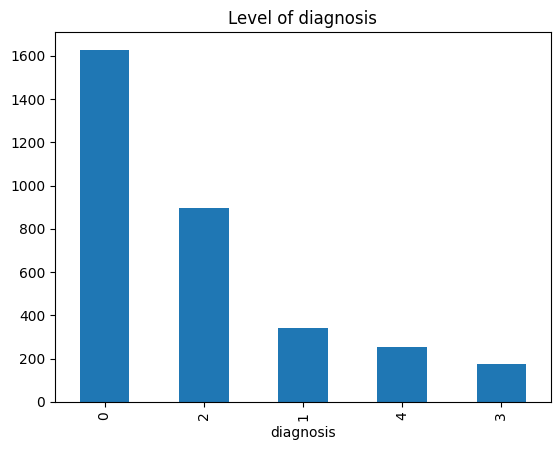

In [5]:
import matplotlib.pyplot as plt
df_train['diagnosis'].value_counts().plot(kind = 'bar')
plt.title("Level of diagnosis")


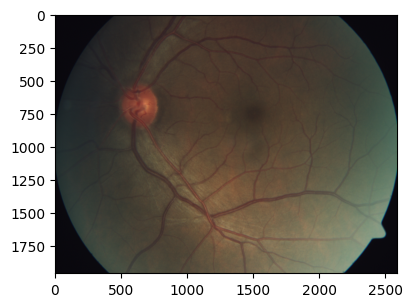

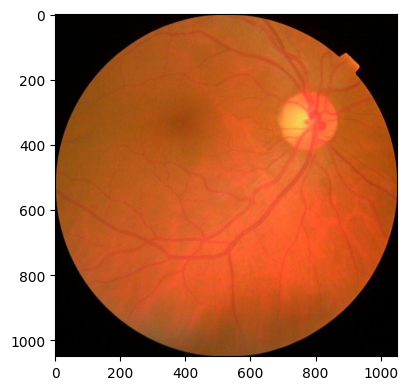

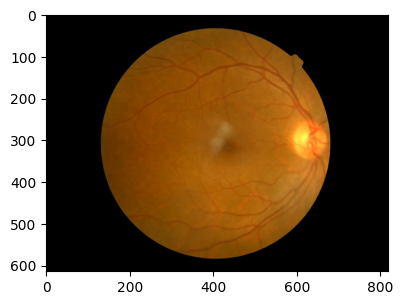

In [6]:
import random
samp = random.sample(df_train['id_code'].tolist(),3)
sub=130
for i in range(len(samp)):
    sub+=1
    plt.figure(figsize=(15,15))
    plt.subplot(sub)
    file_path = "../input/train_images/"+samp[i]+".png"
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)


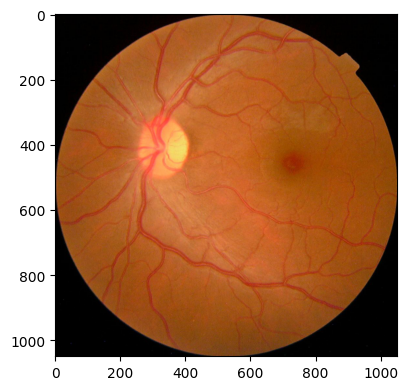

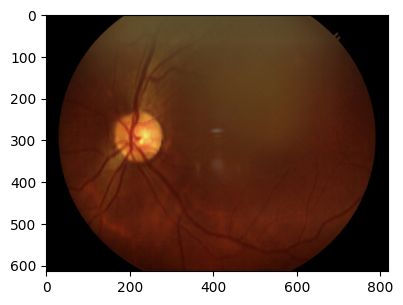

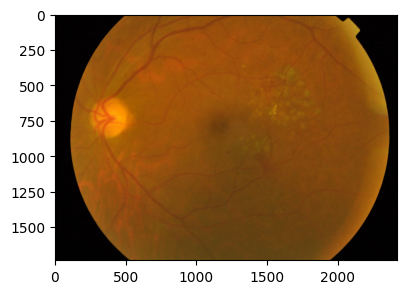

In [7]:
import random
samp = random.sample(df_train['id_code'].tolist(),3)
sub=130
for i in range(len(samp)):
    sub+=1
    plt.figure(figsize=(15,15))
    plt.subplot(sub)
    file_path = "../input/train_images/"+samp[i]+".png"
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)


In [8]:
df_train_img=[]
train_list = df_train["id_code"].tolist()
for item in train_list:
    file_path = "../input/train_images/"+str(item)+".png"
    img = cv2.imread(file_path)
    img = cv2.resize(img,(150,150))
    #print(img)
    df_train_img.append(img)
df_train_img = np.array(df_train_img, np.float32)/255


In [9]:
df_test_img=[]
for item in df_test["id_code"].tolist():
    file_path = "../input/test_images/"+str(item)+".png"
    img = cv2.imread(file_path)
    img = cv2.resize(img,(150,150))
    df_test_img.append(img)
df_test_img = np.array(df_test_img, np.float32)


In [10]:
 y_train = (df_train.iloc[:,1].values).astype('int32')
# from keras.utils.np_utils import to_categorical
# y_train = to_categorical(y_train)


In [11]:
y_train


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [12]:
from sklearn.model_selection import train_test_split
X = df_train_img
Y = y_train
x_train, x_val, y_train, y_val = train_test_split(df_train_img, y_train, test_size = 0.15, random_state = 42)


In [13]:
# df_train_img.reshape(df_train_img.shape[0],150,150,1)


In [14]:
# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                   shear_range = 0.2,
#                                   zoom_range = 0.2,
#                                   horizontal_flip = True)
# test_datagen = ImageDataGenerator(rescale = 1./255)


In [15]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()


AttributeError: module 'keras.preprocessing.image' has no attribute 'ImageDataGenerator'

In [16]:
batches = gen.flow(x_train, y_train, batch_size = 64)
val_batches = gen.flow(x_val, y_val, batch_size = 64)


NameError: name 'gen' is not defined

In [17]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense


In [18]:
classifier = Sequential()
classifier.add(Convolution2D(32, 3 ,3, input_shape = (150,150,3), activation  = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Convolution2D(32,3,3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Flatten())
classifier.add(Dense(output_dim = 75, activation = 'relu'))
classifier.add(Dense(output_dim = 5, activation = 'softmax'))

classifier.compile(optimizer = 'nadam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-19 00:31:45.804085: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


TypeError: Dense.__init__() missing 1 required positional argument: 'units'

In [19]:
hist = classifier.fit_generator(generator=batches, steps_per_epoch = batches.n,
                             epochs=3, validation_data=val_batches,
                             validation_steps=val_batches.n)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [20]:
# predictions.count_values()


In [21]:
predictions = classifier.predict_classes(df_test_img,verbose=0)
sudmissions = pd.DataFrame({'id_code':df_test.iloc[:,0].tolist(),
                           'diagnosis': predictions})
sudmissions.to_csv("submission.csv", index = False, header = True)


AttributeError: 'Sequential' object has no attribute 'predict_classes'